# **A. Instalasi**

In [3]:
%pip install tensorflow


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install opencv-python


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# **B. Import Libraries & Konfiguration**

In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [6]:
# 📁 Path setup
metadata_path = r'C:\Users\Nana Casmana\Documents\KULIAH\PROJECT NANA\PROJECT NANA\skin_disease_detection\data\HAM10000_metadata.csv'
image_dir = r'C:\Users\Nana Casmana\Documents\KULIAH\PROJECT NANA\PROJECT NANA\skin_disease_detection\data\images'
image_size = 224  # Ukuran optimal untuk MobileNetV2

# **C. Load & Explore Data**

In [7]:
# 🔎 Load metadata
df = pd.read_csv(metadata_path)
df['label'] = LabelEncoder().fit_transform(df['dx'])  # encode label ke angka

In [8]:
# 🖼️ Load dan preprocess gambar
images = []
labels = []

for idx, row in df.iterrows():
    img_path = os.path.join(image_dir, row['image_id'] + '.jpg')
    if os.path.exists(img_path):
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        images.append(img_array)
        labels.append(row['label'])

images = np.array(images, dtype='float32')
labels = to_categorical(np.array(labels), num_classes=7)

# **D. Split Data**

In [9]:
# 📊 Split: Train (60%), Val (20%), Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)  # 0.25 x 80% = 20%

In [10]:
# ⚖️ Compute class weights
y_train_int = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights_dict = dict(enumerate(class_weights))

In [11]:
# 🔄 Augmentasi data training
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [12]:
# 🧠 Load MobileNetV2 base
base_model = MobileNetV2(input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

# 🏗️ Build model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# 💾 Callbacks
os.makedirs('models', exist_ok=True)
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('models/skin_model.keras', save_best_only=True)
]


In [14]:
# 🚀 Training
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=20,
                    callbacks=callbacks)


c:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 160s 824ms/step - accuracy: 0.6282 - loss: 1.1528 - val_accuracy: 0.7279 - val_loss: 0.7662
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 148s 785ms/step - accuracy: 0.7138 - loss: 0.8152 - val_accuracy: 0.7264 - val_loss: 0.7454
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 151s 801ms/step - accuracy: 0.7438 - loss: 0.7353 - val_accuracy: 0.7394 - val_loss: 0.7126
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 151s 804ms/step - accuracy: 0.7469 - loss: 0.7229 - val_accuracy: 0.7514 - val_loss: 0.7000
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 165s 877ms/step - accuracy: 0.7593 - loss: 0.6665 - val_accuracy: 0.7434 - val_loss: 0.7053
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 151s 802ms/step - accuracy: 0.7575 - loss: 0.6733 - val_accuracy: 0.7394 - val_loss: 0.7056
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 156s 830ms/step - accuracy: 0.7709 - loss: 0.6373 - val_accuracy: 0.7479 - val_loss: 0.6925
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 144s 767ms/step - accuracy: 0.7668 -

In [19]:
# 🎯 Evaluasi akhir di test set
loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Akurasi Test Set: {acc * 100:.2f}%")


63/63 ━━━━━━━━━━━━━━━━━━━━ 32s 505ms/step - accuracy: 0.7286 - loss: 0.7603
✅ Akurasi Test Set: 74.89%


In [20]:
# 🧾 Classification Report
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred))

63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 540ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.23      0.31        69
           1       0.40      0.45      0.42        93
           2       0.51      0.43      0.47       228
           3       0.00      0.00      0.00        28
           4       0.55      0.36      0.44       226
           5       0.83      0.93      0.88      1338
           6       0.71      0.57      0.63        21

    accuracy                           0.75      2003
   macro avg       0.49      0.43      0.45      2003
weighted avg       0.72      0.75      0.73      2003



c:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Program Files\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


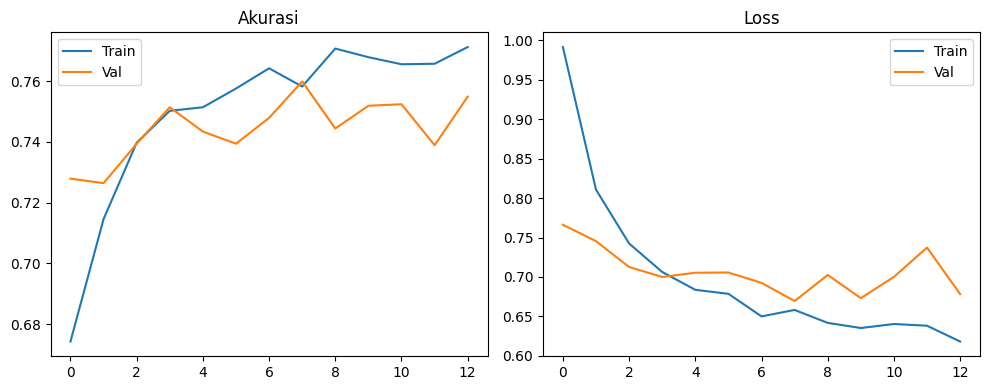

In [21]:

# 📈 Plot akurasi dan loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6156863..0.8901961].


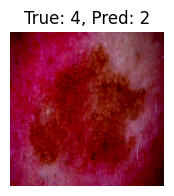

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6627451..1.0].


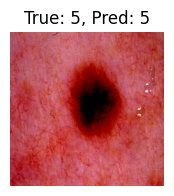

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].


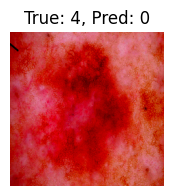

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38823527..1.0].


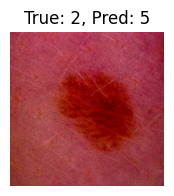

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.58431375].


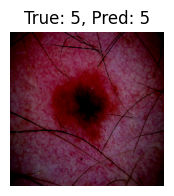

In [30]:
# 💡 Prediksi beberapa contoh gambar uji
# Mengambil beberapa contoh gambar untuk melihat prediksi model
num_examples = 5
for i in range(num_examples):
    img = X_test[i]
    true_label = y_true[i]
    pred_label = y_pred[i]
    
    plt.figure(figsize=(2, 2))
    plt.imshow(img)
    plt.title(f"True: {true_label}, Pred: {pred_label}")
    plt.axis('off')
    plt.show()

In [33]:
model.save(r"C:\Users\Nana Casmana\Documents\KULIAH\PROJECT NANA\PROJECT NANA\skin_disease_detection\models\skin_model_final.keras")